# Machine Learning Model ANN

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,10)})
warnings.filterwarnings('ignore')

In [20]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [21]:
# Dataset generated in previous phase
data = pd.read_csv('./data_f1/cleaned_data.csv')

In [22]:
x = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]

In [23]:
x = x[x['active_constructor']==1]
x = x[x['active_driver']==1]

In [24]:
sc  = StandardScaler()
le = LabelEncoder()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position','active_driver','active_constructor'],1)
y = x['position'].apply(lambda x: position_index(x))

In [25]:
# Separate the test data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

In [27]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(6,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                224       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
Total params: 1,876
Trainable params: 1,876
Non-trainable params: 0
_________________________________________________________________


In [29]:
opt = optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [30]:
callback_list = [
       tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5,
            restore_best_weights=True,
            verbose=1
       )         
]

In [31]:
res = model.fit(x=X_train, 
                y=y_train, 
                epochs=50,
                validation_split=0.2,
                callbacks=callback_list)

Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.7006 - accuracy: 0.7093 - val_loss: 0.5367 - val_accuracy: 0.7877
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.8178 - val_loss: 0.4656 - val_accuracy: 0.8333
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.8401 - val_loss: 0.4477 - val_accuracy: 0.8402
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.8589 - val_loss: 0.4299 - val_accuracy: 0.8447
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.4064 - accuracy: 0.8738 - val_loss: 0.3888 - val_accuracy: 0.8630
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.3757 - accuracy: 0.8841 - val_loss: 0.4086 - val_accuracy: 0.8470
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.3662 - accuracy: 0.8915 - val_loss: 0.3648 - val_accuracy: 0.8813
Epoch 8/50
55/55 [==

In [32]:
df = pd.DataFrame(res.history)
df

,loss,accuracy,val_loss,val_accuracy
0,0.700601,0.709309,0.536750,0.787671
1,0.502180,0.817818,0.465621,0.833333
2,0.459981,0.840091,0.447736,0.840183
3,0.427278,0.858938,0.429897,0.844749
4,0.406405,0.873786,0.388799,0.863014
5,0.375707,0.884066,0.408562,0.847032
6,0.366177,0.891491,0.364778,0.881279
7,0.349309,0.894917,0.391147,0.860731
8,0.334398,0.898915,0.331876,0.908676
9,0.328419,0.892633,0.358120,0.876712


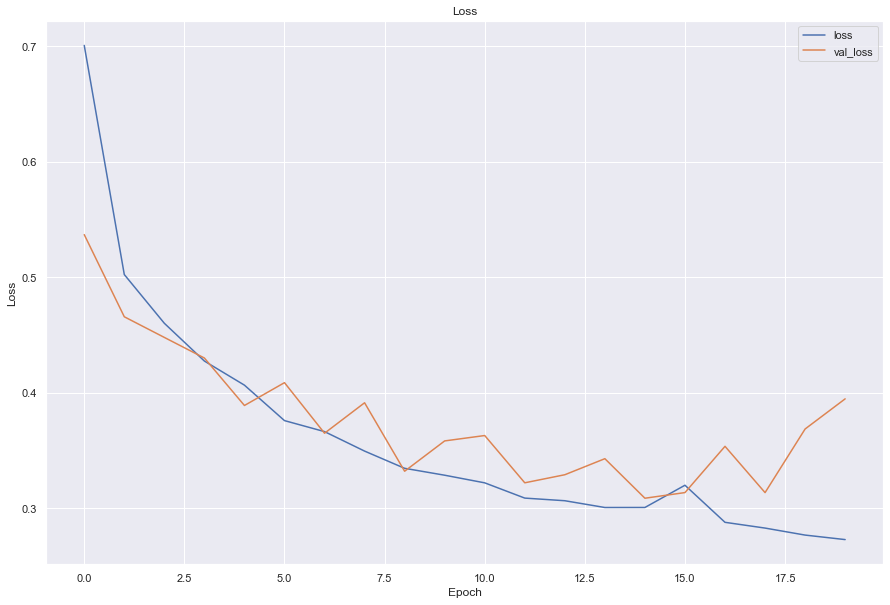

In [33]:
plt.plot(res.epoch, df.loss, label='loss')
plt.plot(res.epoch, df.val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

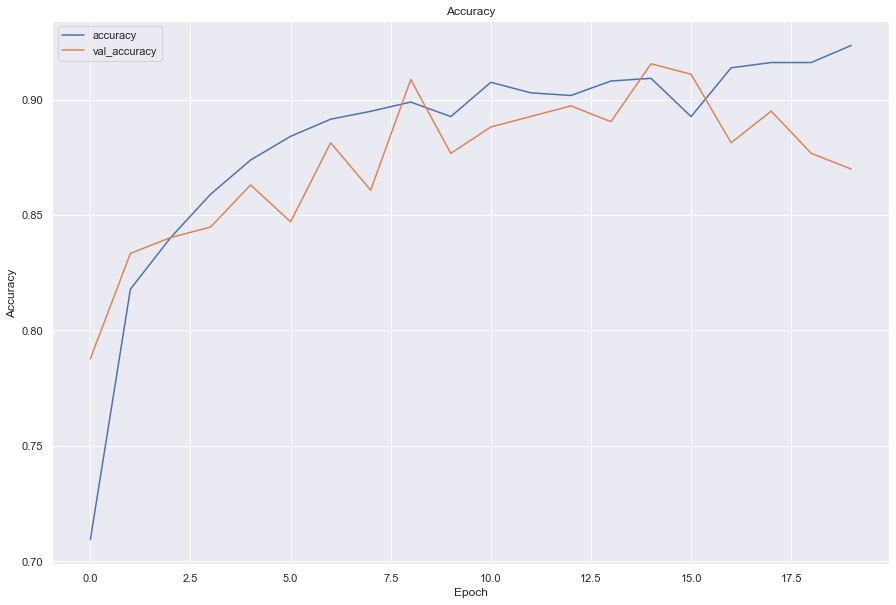

In [34]:
plt.plot(res.epoch, df.accuracy, label='accuracy')
plt.plot(res.epoch, df.val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
# Evaluate model
(test_loss, test_accuracy) = model.evaluate(x=X_test,y=y_test)
print("Loss:", test_loss)
print('Accuracy', test_accuracy)

18/18 [==============================] - 0s 1ms/step - loss: 0.2834 - accuracy: 0.9197
Loss: 0.283430278301239
Accuracy 0.9197080135345459


In [36]:
# assign location
path='./web/model/model.h5'
# save
model.save(path)